# Save a file for each HUC with reach geoms and ids

To make things more cloud-friendly, we want to save a portion of the NHD database in a set of GeoJSON files which can be stored on S3. Each file will have the reach geometries and associated ids.

In [1]:
import json
import os
import collections

import psycopg2
import shapely
import shapely.wkt
import geopandas as gpd
import xarray as xr
import fsspec
import numpy as np
import pyproj
import dask.bag as db
from dask.distributed import Client
import logging

%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


To be able to generate a separate geojson for each of the huc8 units (around 2300) we need the following tables: `wbdhu8` (in database `nhdplushr`) and `nhdflowline` (in database `nhdplusv2`). This is not _the only_ way to do this...it's just that this is how we went about it. To generate each of these tables download all the necessary files pertaining to NHDPlus V2 and NHDPlus HR and follow the instructions of creating the database listed  in the [project's README.md](https://github.com/azavea/noaa-hydro-data#local-database-setup)

In [2]:
def get_cursor(database):
    connection = psycopg2.connect(host='database', database=database,user='postgres', password='password')
    cursor = connection.cursor()
    return cursor

# Get all HUC8s and write a GeoJSON file for each one.

In [3]:
def get_huc8s(database):
    cursor = get_cursor(database)
    query = 'select huc8 from wbdhu8'
    cursor.execute(query)
    return [c[0] for c in cursor]

In [4]:
def save_huc8_extract(huc8, out_dir):
    # get huc8 boundary
    cursor = get_cursor('nhdplushr')
    query = 'SELECT wkb_geometry from wbdhu8 WHERE huc8=%s'
    cursor.execute(query, [huc8])
    ## huc_geom = shapely.wkb.loads(cursor.fetchone()[0].tobytes())
    huc_geom = shapely.wkb.loads(cursor.fetchone()[0], hex=True)

    # get reaches intersecting with huc boundary
    cursor = get_cursor('nhdplusv2')
    query = f'''
        SELECT comid, ST_Force2D(wkb_geometry) from nhdflowline WHERE ST_Intersects(
            ST_Transform(ST_GeomFromEWKB(wkb_geometry), 4326), ST_GeomFromGeoJSON(%s))
        '''
    huc_geom_str = json.dumps(shapely.geometry.mapping(huc_geom))
    cursor.execute(query, [huc_geom_str])
    reach_geoms = []
    reach_ids = []
    for reach_id, reach_geom in cursor:
        reach_ids.append(int(reach_id))
        reach_geoms.append(shapely.wkb.loads(reach_geom, hex=True))

    # make dataframe with comid and geometries and save to GeoJSON
    df = gpd.GeoDataFrame({'comid': reach_ids + [0], 'geometry': reach_geoms + [huc_geom]})
    out_path = os.path.join(out_dir, f'{huc8}.json')
    df.to_file(out_path, driver='GeoJSON', index=False)

Having defined the necessary extract utility functions let's try to generate the json files.

In [5]:
limit = npartitions = 10
client = Client()

huc8s = get_huc8s('nhdplushr')
huc8_out_dir = f'/opt/data/noaa/huc8-extracts/'
os.makedirs(huc8_out_dir, exist_ok=True)
huc8s_processed = [f.replace('.json','') for f in os.listdir(huc8_out_dir)]
if len(huc8s_processed) < len(huc8s):
    huc8s_missing = list(set(huc8s) - set(huc8s_processed))
    huc8_bag = db.from_sequence(huc8s_missing, npartitions=npartitions)
    out8 = huc8_bag.map(save_huc8_extract, huc8_out_dir).compute()


ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


The first time we ran the notebook we generated a geojson for each of the huc8 which contained not only the `comid` of each reach but also it's associated geometry (linestring). However, for our experiments we need only the boundary of huc8 and the associated `comid`s. Therefore, we transform the geojson to extract out the portions that we need for our experiment.

In [6]:
def transform_geojsons(json_dir='/opt/data/noaa/huc8-extracts', out_dir='/opt/data/noaa/huc8-extracts/transformed'):
    
    logger = logging.getLogger('distributed.utils_perf')
    logger.setLevel(logging.ERROR)
    
    jsons = [f for f in os.listdir(json_dir) if f.endswith('.json')]

    for jsonfile in jsons:
        huc8 = jsonfile.replace('.json', '')
        out_path = f'{out_dir}/{huc8}.json'
        if os.path.exists(out_path):
            continue
        dat = gpd.GeoDataFrame.from_file(f'{json_dir}/{jsonfile}', driver='GeoJSON')
        comids = [c for c in dat.loc[:,'comid'][:-1]]
        huc_geom = dat.iloc[-1,:]['geometry']
        gdf = gpd.GeoDataFrame(data = {'huc8': [huc8], 'comids': [comids]}, geometry=[huc_geom], crs='EPSG:4326')
        with open(out_path, 'w') as fw:
            fw.write(gdf.to_json())


transform_geojsons()

**NOTE:** We have to use `gdf.to_json()` instead of `gdf.to_file('02040202.json', driver='GeoJSON')` because neither geopandas nor shapely can read lists from geojsons. Geojsons can contain any json object ([geojson ref](https://datatracker.ietf.org/doc/html/rfc7946#section-3.2)) as properties but geopandas ([see here](https://github.com/geopandas/geopandas/issues/2113)) and fiona ([here](https://github.com/Toblerity/Fiona/issues/738)) are unable to handle list (or array in json).

Index(['id', 'huc8', 'geometry'], dtype='object')
# of features => 1
huc8 => 02040202
first 5 comids => [4491350, 4495894, 4496294, 4491376, 4496504]


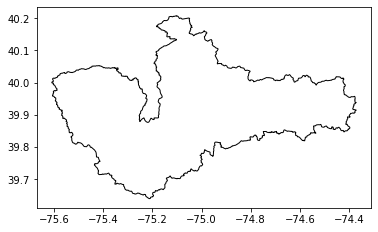

In [8]:
huc8 = '02040202'
fname = f'/opt/data/noaa/huc8-extracts/transformed/{huc8}.json'
d = gpd.read_file(fname,driver='GeoJSON') ## neither fiona nor geopandas can read lists from geojson
d.plot(facecolor='none')
print(d.columns) ## comids column is missing!

with open(fname) as fd:
  js = json.load(fd)
print(f'# of features => {len(js["features"])}')
print(f'huc8 => {js["features"][0]["properties"]["huc8"]}')
print(f'first 5 comids => {js["features"][0]["properties"]["comids"][:5]}')